# Predicting Ames Housing Sales

#### Jump To:
- [Creating Features](#feat)
    - [Visualizations of Selected Features](#viz)
- [Pre-Modeling Funtions](#fun)
- [Modeling](#model)
    - [Linear Regression](#lr)
        - [A Friend Named Poly & Scaly](#poly_scaly)
    - [Regularization](#reg)    
        - [LassoCV](#lasso)
        - [RidgeCV](#ridge)
        - [ElasticCV](#elastic)
    - [Lasso GridSearch](#lassogs)
    - [Visualizations and Final Notes](#viz_fin)

### Imports 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, accuracy_score
from sklearn.linear_model import Lasso, ridge, LinearRegression, LassoCV, ElasticNetCV, RidgeCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

C:\Users\spank\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


### Reading in our datasets
- train and test csv were cleaned and resaved in 'Ames-Training-Data-EDA-Feature.ipynb'

In [2]:
train_df = pd.read_csv('./datasets/train_clean.csv')
test_df = pd.read_csv('./datasets/test_clean.csv')

In [3]:
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Mo Sold,Yr Sold,Sale Type,SalePrice,Has Pool,Has Fence,Has Fireplace,Finished Basement,Total Bath,Total SF
0,109,533352170,60,RL,69.0,13517,Pave,0,IR1,Lvl,...,3,2010,WD,130500,0,0,0,1,2.5,2204.0
1,544,531379050,60,RL,43.0,11492,Pave,0,IR1,Lvl,...,4,2009,WD,220000,0,0,1,1,3.5,3035.0
2,153,535304180,20,RL,68.0,7922,Pave,0,Reg,Lvl,...,1,2010,WD,109000,0,0,0,1,2.0,2114.0
3,318,916386060,60,RL,73.0,9802,Pave,0,Reg,Lvl,...,4,2010,WD,174000,0,0,0,1,2.5,1828.0
4,255,906425045,50,RL,82.0,14235,Pave,0,IR1,Lvl,...,3,2010,WD,138500,0,0,0,1,2.0,2121.0


<a id='feat'> </a>
### Choosing my Features

From the heatmap in my 'Ames-Training-Data-EDA-Feature.ipynb', I could see that there was multicollinearity between:

- Garage Area and Garage Cars (which makes sense, because how many cars you can put in depends on the size of the garage)
- Basement Sqft and 1st Floor Sqft are pretty close to each other, generally if there is a basement it is about the same size as the 1st floor.
- Additionally creating the Total Baths column increased it's correlation, and we can look at baths as a whole instead of in pieces.

In [4]:
# Creating a df of just the features I want to model to begin with
train_feat = train_df[[
    'SalePrice',
    'Overall Qual', # overall qual of home
    'Total SF', # total SF of home inc basement
    'Gr Liv Area', # total sf of 1st & 2nd floor
    'Garage Area', # sf of garage 
    'Total Bath', # total baths in house
    'Year Built',]] # Year built

test_feat = test_df[[
    'Overall Qual',
    'Total SF',
    'Gr Liv Area',
    'Garage Area',
    'Total Bath',
    'Year Built',]]


<a id = 'viz'></a>
### Visualization of Features

#### Correlation of selected Features

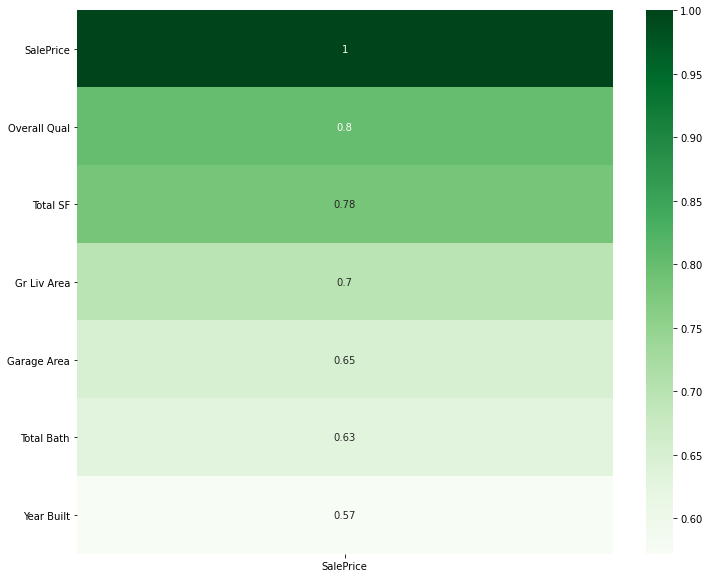

In [5]:
# Showing the correlations of Feature columns to SalesPrice (on train data)
plt.figure(figsize=(12,10))



sns.heatmap(train_feat.corr()[['SalePrice']].sort_values('SalePrice', ascending=False),
            annot=True,
            cmap ='Greens')


plt.yticks(rotation=0);

#### Regression Pairplot of Selected Features

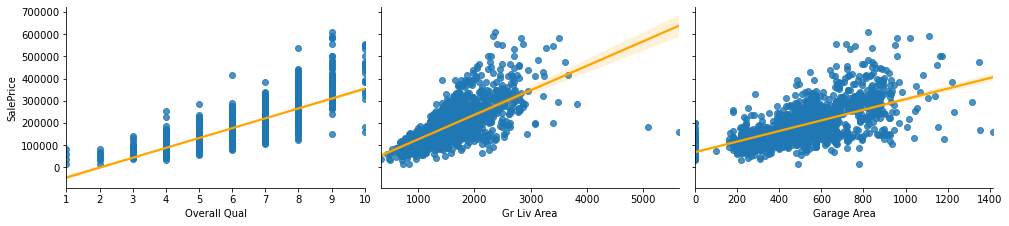

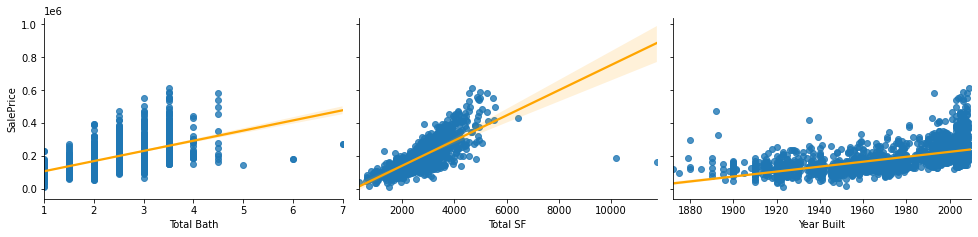

In [6]:
color = ['#66b2b2']
sns.pairplot(train_feat, 
             kind='reg', 
             x_vars= ['Overall Qual', 'Gr Liv Area', 'Garage Area'],
             y_vars = 'SalePrice',
             height = 3,
             aspect = 1.5,
             plot_kws={'line_kws':{'color':'orange'}});


# split into 2 because it was too small to see all 6 in 1 row

sns.pairplot(train_feat, 
             kind='reg', 
             x_vars= ['Total Bath', 'Total SF', 'Year Built'],
             y_vars = 'SalePrice',
             height = 3,
             aspect = 1.5,
             plot_kws={'line_kws':{'color':'orange'}});

#### Outliers
- I dropped the outliers in Gr Liv Area and 1st Flr SF (As the author of the dataset mentioned in the dictionary)
    - However since we are predicting off of the test.csv I could not drop any of those rows in the test.csv, because they were needed in the Kaggle competition

In [7]:
# Dropping the greater than 4000sqft rows, 
train_feat.drop(train_feat[train_feat['Gr Liv Area'] >= 4000].index, inplace=True);

C:\Users\spank\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<a id = 'fun'> </a>
### Some Functions for Ease
- Create a function to make a quick predict csv based on models (since there will be plenty)
- Create a function that prints out metrics / scores of model

In [8]:
## Creating a function that takes the features that we selected from test_c.csv
# Makes a prediction based on which model we used
# Creates a new DF with ID and SalesPrice prediction for that model 
# Saves it as a csv to be submitted

def preds_to_csv(file_name, model, test_X):
    preds = model.predict(test_X) # creating the prediction based on features
    to_submit = pd.DataFrame() # Create a new empty DF 
    to_submit['Id'] = test_df['Id'] # creating a new column with ID
    to_submit['SalePrice'] = preds # creating a new column with our Sales Predictions
    to_submit.to_csv(file_name, index=False) #creating a new csv to be submitted to Kaggle

In [9]:
# Creating a function that outputs the score for my models
def scores(X_train, y_train, X_test, y_test, model):
    
    model = model.fit(X_train, y_train) # fitting the model
    y_preds = model.predict(X_test) #predicting the model off test split
    y_preds_train = model.predict(X_train) # predicting the model off train split
    
    # scoring
    print('Train Score: ', model.score(X_train, y_train))
    print('Test Score: ', model.score(X_test, y_test))
    print('')
    print('R2: ', r2_score(y_test, y_preds))
    print('MAE: ', mean_absolute_error(y_test, y_preds))
    print('MSE: ', mean_squared_error(y_test, y_preds))
    print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_preds_train)))
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_preds)))

<a id='model'></a>
### Modeling

#### Let's give it a try
- Setting up my X and y, train/test split


In [10]:
# Choosing my X and y for first model
X = train_feat.drop(['SalePrice'], axis = 'columns')
y = train_feat['SalePrice']

In [11]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<a id='lr'></a>
#### Linear Regression

In [12]:
# Instantiating my model
lr = LinearRegression()

In [13]:
# Baseline Score
cross_val_score(lr,X,y, cv=5).mean()

0.8258297543672057

In [14]:
# Fit predict and score
scores(X_train, y_train, X_test, y_test, lr)

Train Score:  0.8186154391231057
Test Score:  0.8386409167264735

R2:  0.8386409167264735
MAE:  23449.939701684518
MSE:  1045634927.0927448
Train RMSE:  33464.79306294915
Test RMSE:  32336.27880713464


- Score difference between train and test shows slight overfitting, Train score is lower than baseline
- RMSE difference is good, but all together high
- Kaggle RMSE score: 37027.42

In [15]:
# A quick coef_ table to show feature and coef, pretty good. 
lr_coef = pd.DataFrame((list(zip(X.columns, lr.coef_))),columns = ['Features', 'Coefficient'])
lr_coef

,Features,Coefficient
0,Overall Qual,18221.983047
1,Total SF,39.301446
2,Gr Liv Area,14.236857
3,Garage Area,41.453704
4,Total Bath,6970.146215
5,Year Built,260.900571


With this model, holding all else constant for each 1 unit increase in the Features the SalePrice increases by the Coefficient amount. 
For every SF increase in the total of the home the SalePrice goes up by $39

In [16]:
#preds_to_csv('./datasets/Kaggle Submissions/first_submit.csv', lr, test_feat)

<a id='poly_scaly'></a>
#### Creating PolynomialFeatures 

In [17]:
## Creating polynomial features of our selected features only
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)

X_poly_test = poly.fit_transform(test_feat) # create a poly in our test dataset

In [18]:
# new train test split with poly
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)

#### Standard Scaler

In [19]:
# Using Standard Scaler because there is a variance in model (max 7 baths and $$ SalesPrice)\

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

X_poly_test_sc = ss.transform(X_poly_test) # Again getting it ready for pred submission

In [20]:
scores(X_train_sc, y_train, X_test_sc, y_test, lr)
y_preds = lr.predict(X_test_sc)

Train Score:  0.8839856139716706
Test Score:  0.8896104781376409

R2:  0.8896104781376409
MAE:  18342.13920481283
MSE:  697895203.633752
Train RMSE:  26975.4926311044
Test RMSE:  26417.706252317817


Trying Linear Regression again with the change
- Better score difference between train and test, lower RMSE
- Kaggle RMSE score: 29072.82

In [21]:
#preds_to_csv('./datasets/Kaggle Submissions/second_submit.csv', lr, X_poly_test_sc)

<a id = 'reg'></a>
### Regularization
- I am going to try all 3 Regularizations and see which gets best score without over fitting
- Then I will gridsearch best hyperparams for the winner

<a id='ridge'></a>
#### RidgeCV

In [22]:
ridgecv = RidgeCV()
scores(X_train_sc, y_train, X_test_sc, y_test, ridgecv)
#preds_to_csv('./datasets/Kaggle Submissions/ridgecv_submit.csv', ridgecv, X_poly_test_sc)

Train Score:  0.8829626821420448
Test Score:  0.8905423763920084

R2:  0.8905423763920084
MAE:  18240.153111396412
MSE:  692003636.10972
Train RMSE:  27094.15692539004
Test RMSE:  26305.961987916733


- Kaggle RMSE score: 29620.10

<a id ='lasso'></a>
#### LassoCV

In [23]:
lassocv = LassoCV()
scores(X_train_sc, y_train, X_test_sc, y_test, lassocv)
lassocv.alpha_
# preds_to_csv('./datasets/Kaggle Submissions/lassocv_submit.csv', lassocv, X_poly_test_sc)

Train Score:  0.8804440790416996
Test Score:  0.8886226618119406

R2:  0.8886226618119406
MAE:  18587.049775261767
MSE:  704140291.610824
Train RMSE:  27384.13367987569
Test RMSE:  26535.641910660914


C:\Users\spank\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94249329912.71875, tolerance: 963425504.023345
  model = cd_fast.enet_coordinate_descent(


72.71071339360124

- Kaggle RMSE score: 29409.22

<a id='elastic'></a>
#### ElasticCV

In [24]:
elasticcv = ElasticNetCV()
scores(X_train_sc, y_train, X_test_sc, y_test, elasticcv)

Train Score:  0.3054966508651953
Test Score:  0.30484531917352986

R2:  0.30484531917352986
MAE:  47632.044575037515
MSE:  4394847530.341295
Train RMSE:  66001.01794443149
Test RMSE:  66293.6462290414


- Even though the train test score are close to eachother (not over fitting)
    - The score is pretty low
    - The RMSE is still alot higher than the others
- I'm not going to submit to Kaggle    

Based on the three models above I have decided to move forward with Lasso. Next I will use GridSearchCV to find the best alpha for my Lasso model

<a id='lassogs'></a>
### Grid Search


In [25]:
# Since Lasso did the best score above, I want to do a grid search for the best alpha for Lasso 
lasso_params = {
    'alpha' : range(100, 1051, 1), # start at 100 alpha, go up to 1050 and do 1 step
}

In [26]:
lasso_gridsearch = GridSearchCV(Lasso(),
                               lasso_params,
                               cv=5,
                               verbose = 1,
                               n_jobs=-1) # use all of the processor

### RUN AT OWN  RISK! 
- The GridSearch: Fit 5 folds for each of 951 candidates, totalling 4755 fits
    - Took 10sec for me
    
- The output:
|   |   |   | 
|---|---|---|
|Train Score:|   |0.8797091526950478  |
|Test Score:|  | 0.8897704375724536 |
|R2:   |   |0.8897704375724536  |
|MAE:|   |18594.327640002968|
|MSE:|  | 696883921.7616292|
|Train RMSE: | |27468.1717082387|
|Test RMSE:  |   |26398.559084950626|

        - Best score : 0.8730356958329756
        - Best params : {'alpha': 106}

In [27]:
#Run at your own risk
scores(X_train_sc, y_train, X_test_sc, y_test, lasso_gridsearch)

Fitting 5 folds for each of 951 candidates, totalling 4755 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:    9.8s


Train Score:  0.8798657836808591
Test Score:  0.8896716816065584

R2:  0.8896716816065584
MAE:  18599.17726072669
MSE:  697508268.2916776
Train RMSE:  27450.282698590505
Test RMSE:  26410.38182782819


[Parallel(n_jobs=-1)]: Done 4732 out of 4755 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 4755 out of 4755 | elapsed:   14.8s finished
C:\Users\spank\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58646232717.996216, tolerance: 963425504.023345
  model = cd_fast.enet_coordinate_descent(


- Best Score yet, minimal overfitting
- Kaggle RMSE score : 26347.73

In [28]:
print(lasso_gridsearch.best_params_)

{'alpha': 108}


In [29]:
lasso_gridsearch.best_score_

0.8731610885882002

In [30]:
#preds_to_csv('./datasets/Kaggle Submissions/lassogs_3_submit.csv', lasso_gridsearch, X_poly_test_sc)

<a id ='viz_fin'></a>
## Visualizations and Final Notes

#### Re modeling my Lasso to get more info

In [31]:
# same info as above but since gridsearch does not have coef_ I wanted to put
#it straight through Lasso

lasso = Lasso(alpha=108, tol=0.01) # increased tolerance because I got a warning
scores(X_train_sc, y_train, X_test_sc, y_test, lasso)

Train Score:  0.8801202444707213
Test Score:  0.8895491444133761

R2:  0.8895491444133761
MAE:  18592.254899524938
MSE:  698282962.465055
Train RMSE:  27421.195551054236
Test RMSE:  26425.044228251634


In [32]:
print(f'The Average SalePrice in our predicted model is ${lasso.intercept_.round(2)}')

The Average SalePrice in our predicted model is $181486.2


In [33]:
# A table of coefficients for easier viewing
train_df_coef = pd.DataFrame((list(zip(poly.get_feature_names(X.columns), lasso.coef_))),columns = ['Features', 'Coefficient'])
train_df_coef

,Features,Coefficient
0,Overall Qual,-3587.566689
1,Total SF,-1060.603695
2,Gr Liv Area,-0.000000
3,Garage Area,-0.000000
4,Total Bath,-1722.475151
5,Year Built,10224.970361
6,Overall Qual^2,-2237.727928
7,Overall Qual Total SF,88749.606609
8,Overall Qual Gr Liv Area,960.558850
9,Overall Qual Garage Area,8505.425569


- It is interesting that Lasso cut out Gr Liv Area (Above grade living area) and the Garage Area in it's model prediction.
Since Gr Liv Area is typically 1st flr SF and 2nd flr SF it is counted into Total SF which includes the 2 and the basement.
- Also somewhere between my original LinearRegression and creating PolynomialFeatures the coefficient of TotalSF went negative.

In [34]:
# Dropping all the 'cut out' features from my coef_ table,
train_df_coef = train_df_coef[train_df_coef['Coefficient'] != 0]
train_df_coef

,Features,Coefficient
0,Overall Qual,-3587.566689
1,Total SF,-1060.603695
4,Total Bath,-1722.475151
5,Year Built,10224.970361
6,Overall Qual^2,-2237.727928
7,Overall Qual Total SF,88749.606609
8,Overall Qual Gr Liv Area,960.558850
9,Overall Qual Garage Area,8505.425569
10,Overall Qual Total Bath,12369.130402
11,Overall Qual Year Built,-17922.953364


#### Showing my top 5 Features that have a positive correlation to SalePrice

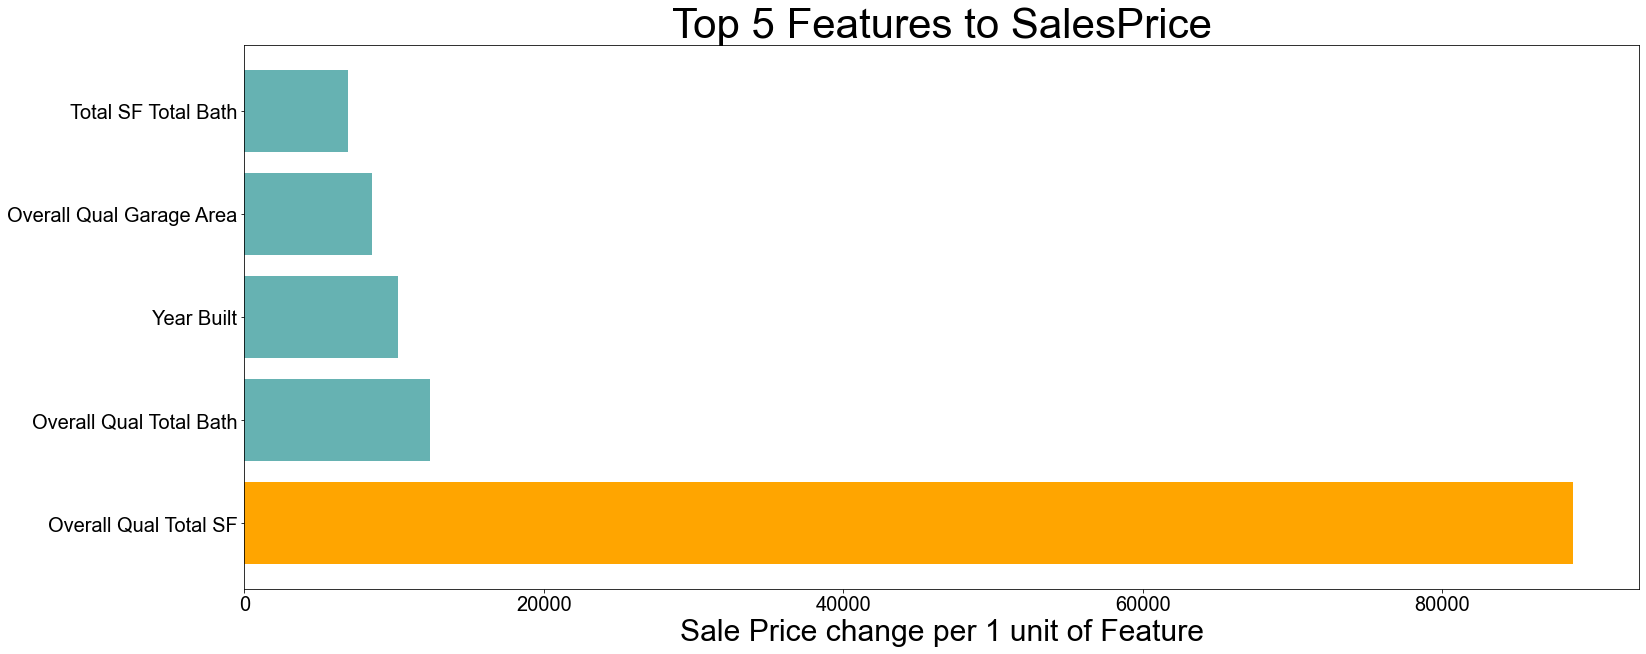

In [35]:
inter = lasso.intercept_ # Average of predicted 
coef = train_df_coef # unit increase to $
coef.set_index(coef.Features, inplace=True) # so y label shows right

coef_unit = coef.sort_values('Coefficient', ascending=False)['Coefficient'].head() # sort by coefficient show top 5
color = ['orange' if i > 50000 else '#66b2b2' for i in coef_unit]

labels = coef_unit.index #only labels of selected

plt.figure(figsize=(25,10))
plt.barh(labels, coef_unit, color = color)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Sale Price change per 1 unit of Feature', fontsize=30)
plt.title(f'Top 5 Features to SalesPrice', fontsize=42);



#### Showing All Features to Correlations

In [39]:
coef.head()

,Features,Coefficient
Features,,
Overall Qual,Overall Qual,-3587.566689
Total SF,Total SF,-1060.603695
Total Bath,Total Bath,-1722.475151
Year Built,Year Built,10224.970361
Overall Qual^2,Overall Qual^2,-2237.727928
Overall Qual Total SF,Overall Qual Total SF,88749.606609
Overall Qual Gr Liv Area,Overall Qual Gr Liv Area,960.558850
Overall Qual Garage Area,Overall Qual Garage Area,8505.425569
Overall Qual Total Bath,Overall Qual Total Bath,12369.130402


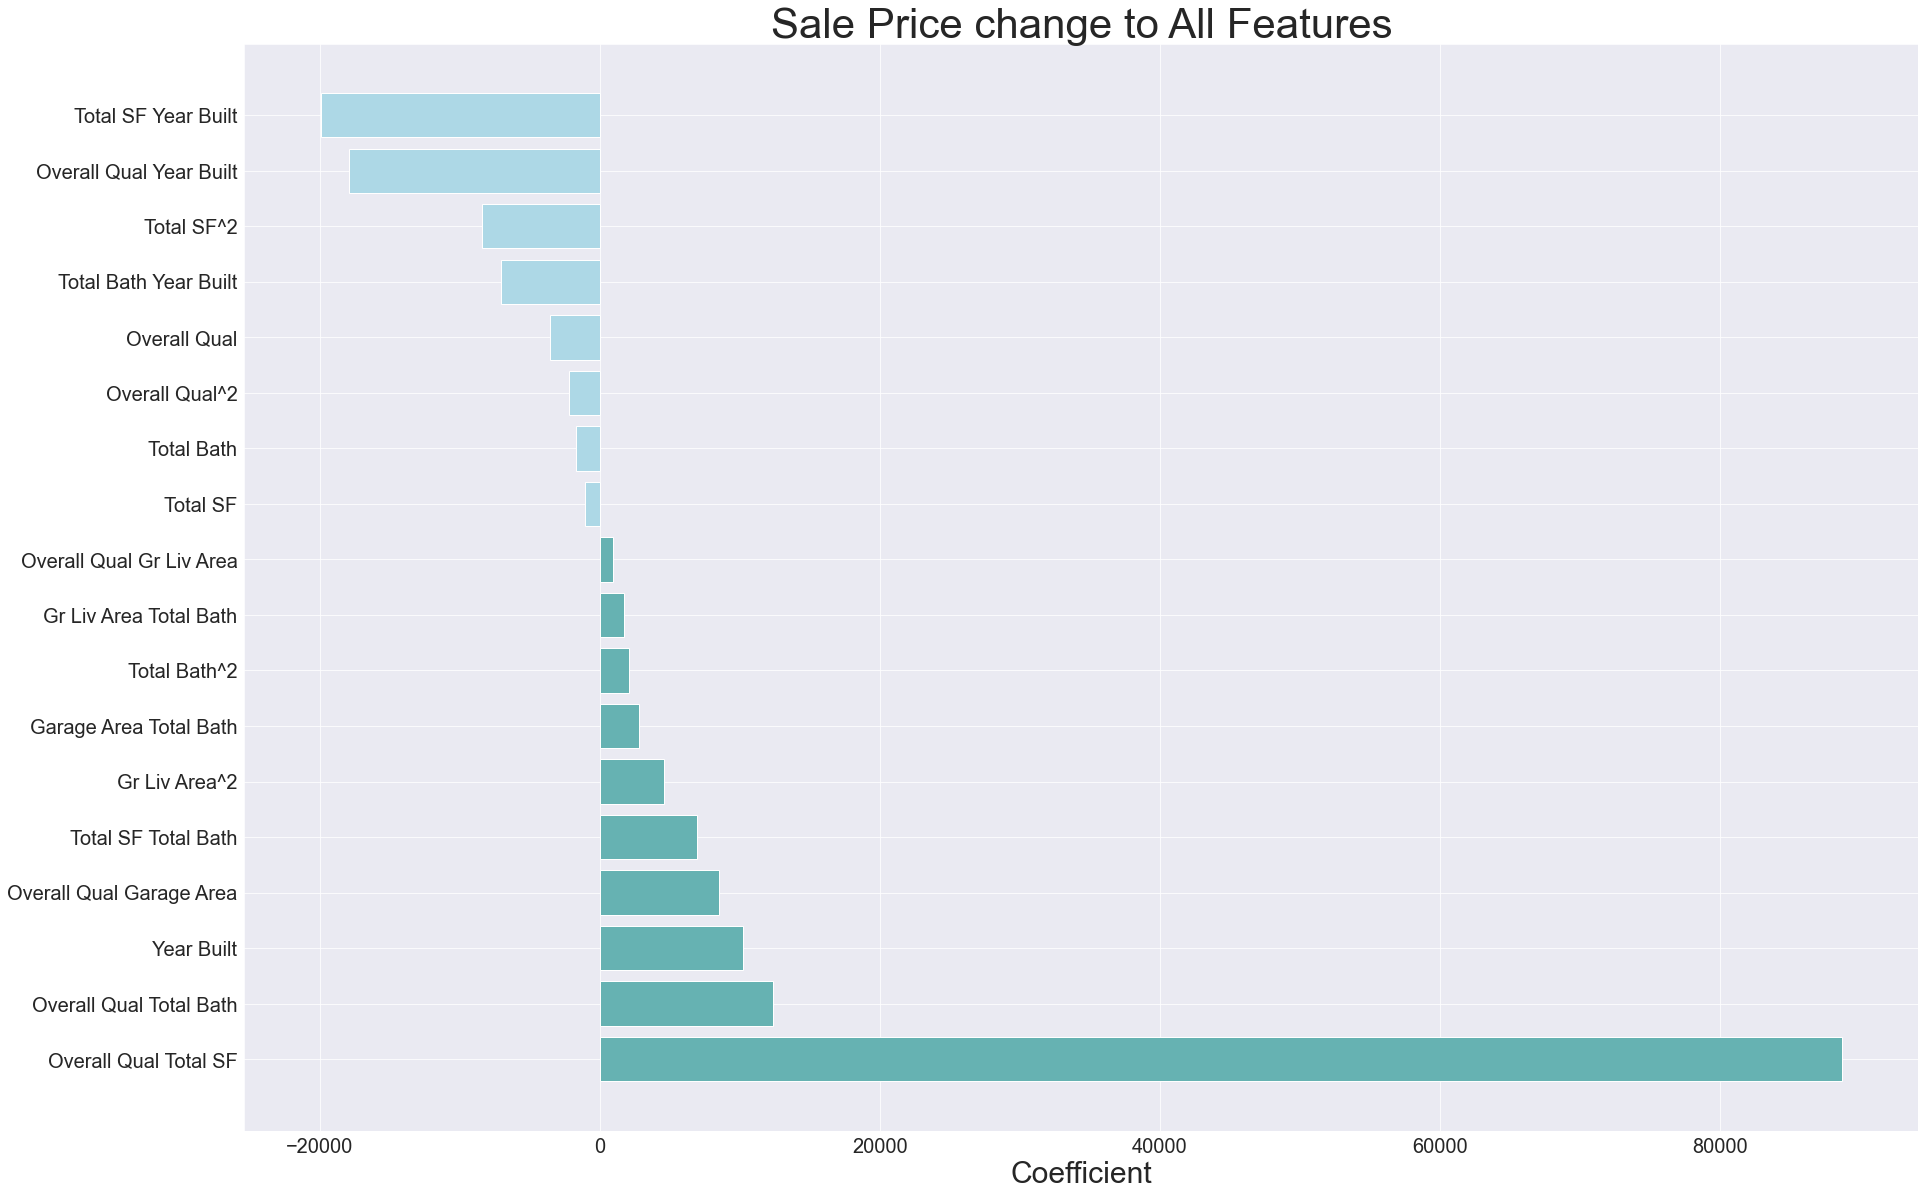

In [37]:
# make a new column to bool if value is positive or negative for color
coef_unit = coef.sort_values('Coefficient', ascending=False)['Coefficient']
color = ['#66b2b2' if i > 0 else 'lightblue' for i in coef_unit]# Showing all instead of just top 5
labels = coef_unit.index

plt.figure(figsize=(30,20))
plt.barh(labels, coef_unit, color = color)#coef.pos.map({'yes': 'lightgreen', 'no': 'lightblue'})) #not working properly right now
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Coefficient', fontsize=30)
plt.title(f'Sale Price change to All Features', fontsize=42);


### Actual vs. Predicted

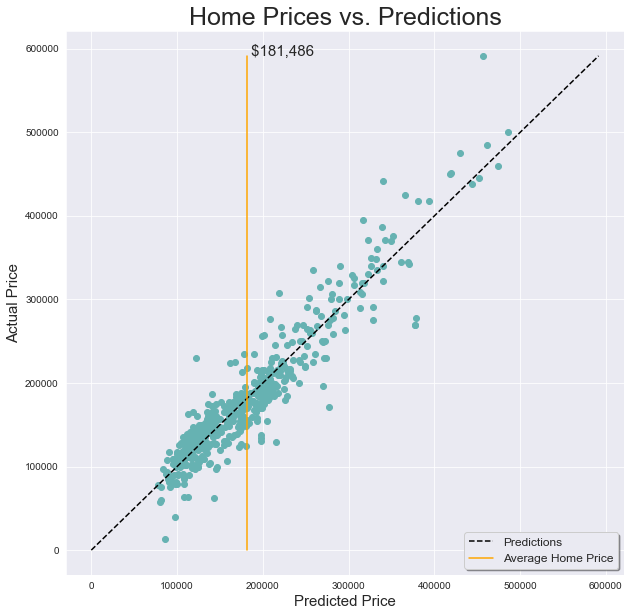

In [38]:
preds = lasso.predict(X_test_sc) # predicting outside of the function

plt.figure(figsize=(10,10))
plt.scatter(preds, y_test, label=None, c='#66b2b2') # predictions and 'y_true of test split'

#lines
plt.plot((0, y_test.max()), (0,y_test.max()), 'k--', label='Predictions')
plt.plot((181486, 181486), (0,y_test.max()), '-', color='orange', label='Average Home Price')

plt.title('Home Prices vs. Predictions', fontsize=25)
plt.xlabel('Predicted Price', fontsize=15)
plt.ylabel('Actual Price', fontsize=15)

plt.annotate(' $181,486', (181486,y_test.max()), fontsize=15)

plt.legend(fontsize=12, loc='lower right', shadow='True');

My residuals are pretty close
- There is still an outlier in the dataset a home sold for 600k and some others (bathrooms that are more than 5 for example) I should have cleaned up.
- Figure out why my coef_ became negative.
- After I got a good score here I did another notebook with One-Hot which while it got really good scores in the training dataset, it did the worst against the Kaggle test dataset